## Homework 01. Simple text processing.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
from IPython import display
from math import log
from collections import Counter
import re
from sklearn.linear_model import LogisticRegression
from itertools import chain

from utils import plot_train_process


In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

*Disclaimer: The used dataset may contain obscene language and is used only as an example of real unfiltered data.*

In [3]:
# In colab uncomment this cell
# ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/homeworks/homework01/utils.py -nc

<IPython.core.display.Javascript object>

In [4]:
try:
    data = pd.read_csv("../../datasets/comments_small_dataset/comments.tsv", sep="\t")
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep="\t")

File ‘comments.tsv’ already there; not retrieving.



<IPython.core.display.Javascript object>

In [5]:
data.head(10)

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...
5,0,"""\n\n JSTOR \n\nHi there. You're one of the fi..."
6,1,"It was a lie, a fucking lie."
7,1,HA! \n\nHA! I still continue to edit yet! Serv...
8,0,"""I personally think it was the luckiest goal i..."
9,0,"I'm no expert, but I think use like that is al..."


<IPython.core.display.Javascript object>

In [6]:
texts = data["comment_text"].values
target = data["should_ban"].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


<IPython.core.display.Javascript object>

In [7]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = train_test_split(
    texts, target, test_size=0.5, random_state=42
)

<IPython.core.display.Javascript object>

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [8]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
preprocess = lambda text: " ".join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print(
    "before:",
    text,
)
print(
    "after:",
    preprocess(text),
)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


<IPython.core.display.Javascript object>

In [9]:
# task: preprocess each comment in train and test
texts_train = [preprocess(txt) for txt in texts_train]
texts_test = [preprocess(txt) for txt in texts_test]

<IPython.core.display.Javascript object>

In [10]:
# Small check that everything is done properly
assert texts_train[5] == "who cares anymore . they attack with impunity ."
assert texts_test[89] == "hey todds ! quick q ? why are you so gay"
assert len(texts_test) == len(y_test)

<IPython.core.display.Javascript object>

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [11]:
from collections import Counter

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(" ".join(texts_train).split())))


def prepare_dictionary(dataset, k=None):
    counter = Counter()

    for txt in dataset:
        counter.update(txt.split())

    return counter if k is None else counter.most_common(k)


bow_vocabulary = [t[0] for t in prepare_dictionary(texts_train, k)]
bow_vocabulary_np_array = np.array(bow_vocabulary)
print("example features:", sorted(bow_vocabulary)[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', '←']


<IPython.core.display.Javascript object>

In [12]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    # <YOUR CODE>
    counts = np.zeros_like(bow_vocabulary_np_array, dtype="float32")

    for w in text.split():
        counts += bow_vocabulary_np_array == w

    return counts

<IPython.core.display.Javascript object>

In [13]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

<IPython.core.display.Javascript object>

In [14]:
# Small check that everything is done properly
k_max = len(set(" ".join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(
    X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in texts_train[5:10]])
)
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index(".")] == texts_train[6].split().count(".")

<IPython.core.display.Javascript object>

Now let's do the trick with `sklearn` logistic regression implementation:

In [15]:
bow_model = LogisticRegression().fit(X_train_bow, y_train)

<IPython.core.display.Javascript object>

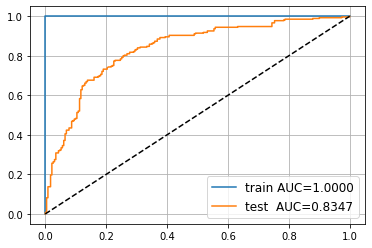

<IPython.core.display.Javascript object>

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ("train", X_train_bow, y_train, bow_model),
    ("test ", X_test_bow, y_test, bow_model),
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [17]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

<IPython.core.display.Javascript object>

In [18]:
from utils import plot_train_process

<IPython.core.display.Javascript object>

In [19]:
model = nn.Sequential()

### YOUR CODE HERE

model.add_module("l1", nn.Linear(len(bow_vocabulary), 2))

<IPython.core.display.Javascript object>

In [20]:
len(bow_vocabulary)

5707

<IPython.core.display.Javascript object>

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [21]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, patience=10)

<IPython.core.display.Javascript object>

In [22]:
X_train_bow_torch = torch.from_numpy(X_train_bow.astype("float32"))
X_test_bow_torch = torch.from_numpy(X_test_bow.astype("float32"))

y_train_torch = torch.tensor(y_train)
y_test_torch = torch.tensor(y_test)

<IPython.core.display.Javascript object>

Let's test that everything is fine

In [23]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

<IPython.core.display.Javascript object>

In [24]:
assert type(loss.item()) == float

<IPython.core.display.Javascript object>

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [25]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10,
):
    if not warm_start:
        for name, module in model.named_children():
            print("resetting ", name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print("Cannot reset {} module parameters: {}".format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):
        # clear gradients
        opt.zero_grad()
        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to("cpu").detach().numpy(),
                y_predicted.to("cpu").detach().numpy().argmax(axis=1),
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(
                loss_function(predictions_val, y_val_torch).to("cpu").detach().item()
            )

            acc_score_val = accuracy_score(
                y_val_torch.cpu().numpy(),
                predictions_val.to("cpu").detach().numpy().argmax(axis=1),
            )
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(
                    train_loss_history,
                    val_loss_history,
                    train_acc_history,
                    val_acc_history,
                )
    return model

<IPython.core.display.Javascript object>

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

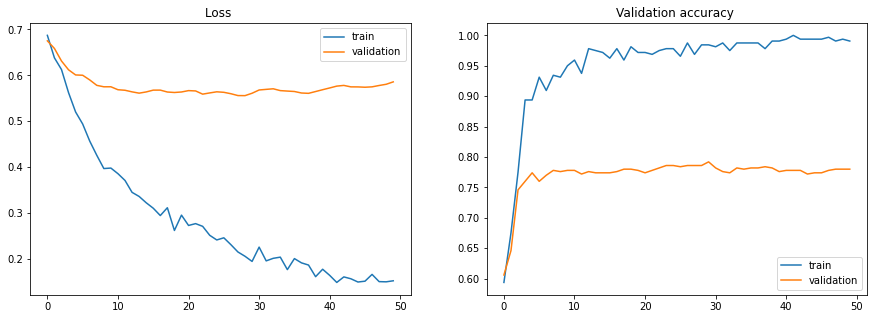

Sequential(
  (l1): Linear(in_features=5707, out_features=2, bias=True)
)

<IPython.core.display.Javascript object>

In [26]:
train_model(
    model,
    opt,
    lr_scheduler,
    X_train_bow_torch,
    y_train_torch,
    X_test_bow_torch,
    y_test_torch,
)

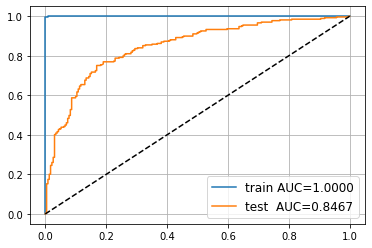

<IPython.core.display.Javascript object>

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ("train", X_train_bow_torch, y_train, model),
    ("test ", X_test_bow_torch, y_test, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

**Let's increase iteration for train to 2000**

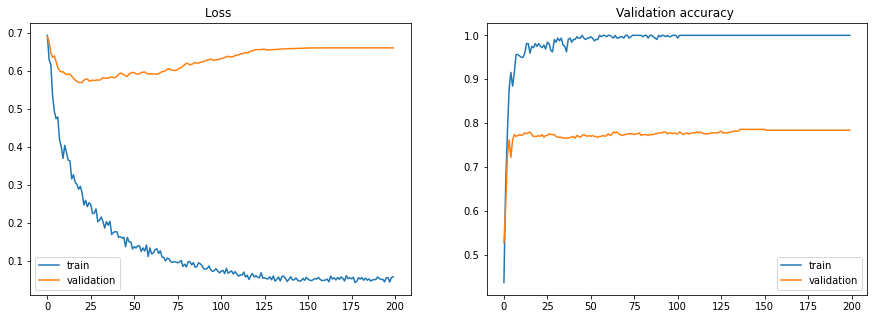

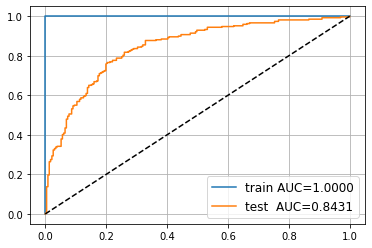

<IPython.core.display.Javascript object>

In [28]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, patience=10)

train_model(
    model,
    opt,
    lr_scheduler,
    X_train_bow_torch,
    y_train_torch,
    X_test_bow_torch,
    y_test_torch,
    n_iterations=2_000,
)

for name, X, y, model in [
    ("train", X_train_bow_torch, y_train, model),
    ("test ", X_test_bow_torch, y_test, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

**We can see that our model is overfitted. let's change lr->1e-4 and batch_size -> 64, n_iterations->1000**

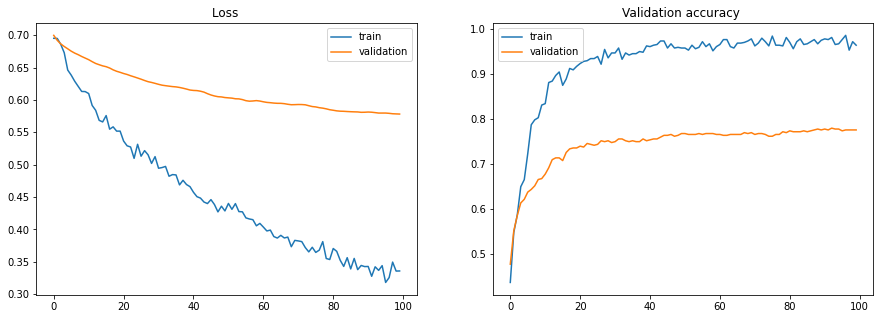

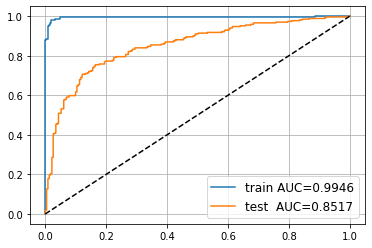

<IPython.core.display.Javascript object>

In [29]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, patience=10)

train_model(
    model,
    opt,
    lr_scheduler,
    X_train_bow_torch,
    y_train_torch,
    X_test_bow_torch,
    y_test_torch,
    n_iterations=1_000,
    batch_size=64,
)

for name, X, y, model in [
    ("train", X_train_bow_torch, y_train, model),
    ("test ", X_test_bow_torch, y_test, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

**Ok, we can see that default configuration is not bad and let's change number of tokens**

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [30]:
result = []
for k in range(100, 5000, 500):

    bow_vocabulary = [t[0] for t in prepare_dictionary(texts_train, k)]
    bow_vocabulary_np_array = np.array(bow_vocabulary)

    model = nn.Sequential()

    model.add_module("l1", nn.Linear(len(bow_vocabulary), 2))

    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    lr_scheduler = ReduceLROnPlateau(opt, patience=10)

    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

    X_train_bow_torch = torch.from_numpy(X_train_bow.astype("float32"))
    X_test_bow_torch = torch.from_numpy(X_test_bow.astype("float32"))

    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)

    train_model(
        model,
        opt,
        lr_scheduler,
        X_train_bow_torch,
        y_train_torch,
        X_test_bow_torch,
        y_test_torch,
        show_plots=False,
    )

    result.append(
        {
            "k": k,
            "train": {"x": X_train_bow_torch, "y": y_train},
            "test": {"x": X_test_bow_torch, "y": y_test},
            "model": model,
        }
    )

resetting  l1
resetting  l1
resetting  l1
resetting  l1
resetting  l1
resetting  l1
resetting  l1
resetting  l1
resetting  l1
resetting  l1


<IPython.core.display.Javascript object>

k = 100


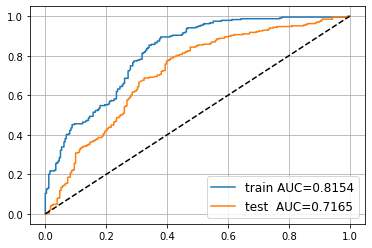

k = 600


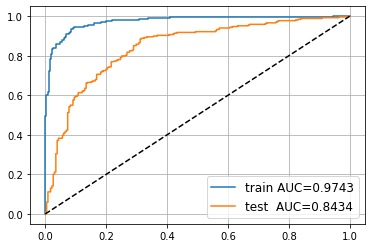

k = 1100


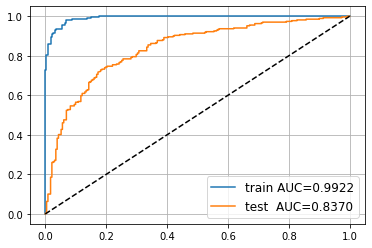

k = 1600


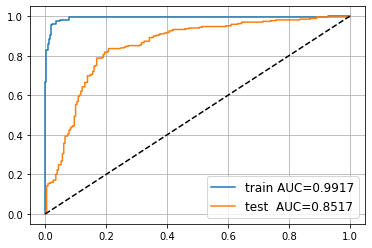

k = 2100


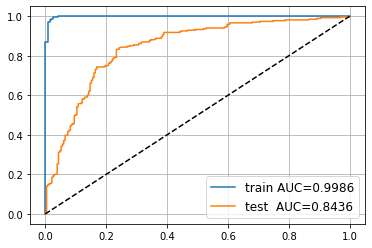

k = 2600


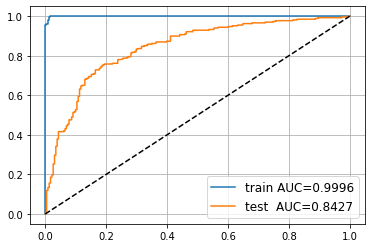

k = 3100


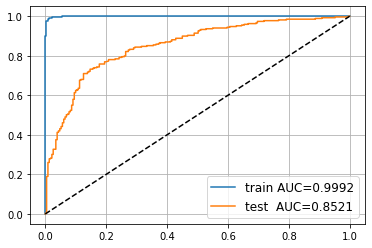

k = 3600


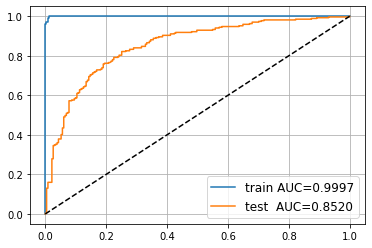

k = 4100


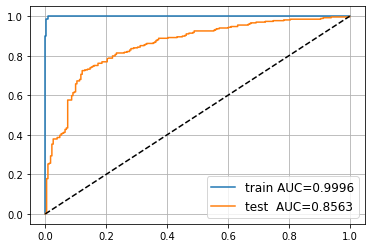

k = 4600


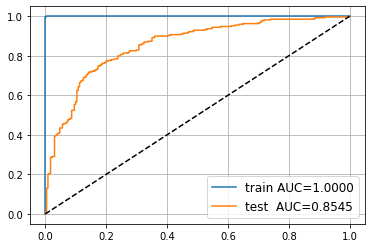

<IPython.core.display.Javascript object>

In [31]:
for m in result:

    print(f"k = {m['k']}")

    for name, X, y, model in [
        ("train", m["train"]["x"], m["train"]["y"], m["model"]),
        ("test ", m["test"]["x"], m["test"]["y"], m["model"]),
    ]:
        proba = model(X).detach().cpu().numpy()[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

    plt.plot(
        [0, 1],
        [0, 1],
        "--",
        color="black",
    )
    plt.legend(fontsize="large")
    plt.grid()
    plt.show()

**Vocabulary with size 100 is not enough to generalize the data for classification but we can see that k = 2600 is optimal and we can 2600 instead ~5700 as the default value. It means that we can reduce the model 2 times**

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [32]:
def tfidf_dataset(dataset_train, dataset_test):
    tokenized = list(map(str.split, dataset_train))
    words = {w: i for i, w in enumerate(set(chain.from_iterable(tokenized)))}

    corpus_size = len(tokenized)
    document_counts = Counter()

    for text in tokenized:
        document_counts.update(set(text))

    idf = {
        term: np.log(corpus_size / (count + 1))
        for term, count in document_counts.items()
    }

    train_features = []

    for tokenized_doc in tokenized:
        word_counter = Counter(tokenized_doc)
        vector = np.zeros(len(words), dtype=np.float32)

        for word, count in word_counter.items():
            if word in words:
                vector[words[word]] = word_counter[word] * idf[word]

        train_features.append(vector / (np.linalg.norm(vector, ord=1) + 1e-8))

    train_features_stack = np.stack(train_features)

    test_features = []

    for tokenized_doc in list(map(str.split, dataset_test)):
        word_counter = Counter(tokenized_doc)
        vector = np.zeros(len(words), dtype=np.float32)

        for word, count in word_counter.items():
            if word in words:
                vector[words[word]] = word_counter[word] * idf[word]

        test_features.append(vector / (np.linalg.norm(vector, ord=1) + 1e-8))

    test_features_stack = np.stack(test_features)

    return train_features_stack, test_features_stack

<IPython.core.display.Javascript object>

In [33]:
tfidf_train, tfidf_test = tfidf_dataset(texts_train, texts_test)

<IPython.core.display.Javascript object>

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [34]:
X_train_tfidf_torch = torch.from_numpy(tfidf_train.astype("float32"))
X_test_tfidf_torch = torch.from_numpy(tfidf_test.astype("float32"))

model = nn.Sequential()

model.add_module("l1", nn.Linear(tfidf_train.shape[1], 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)  # lr=5e-4)
lr_scheduler = StepLR(opt, 100)

<IPython.core.display.Javascript object>

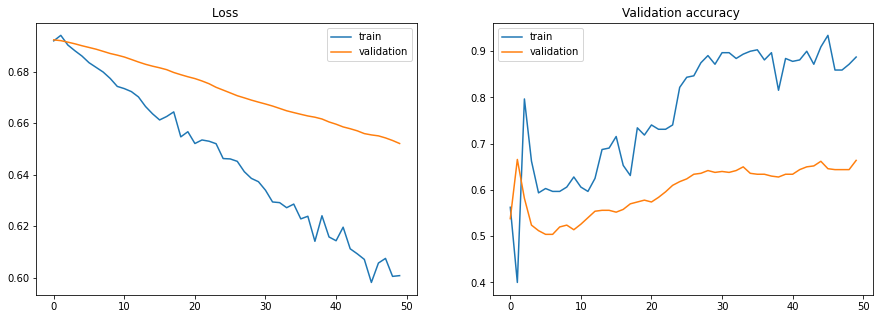

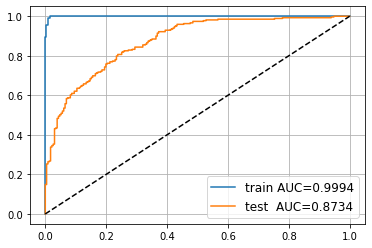

<IPython.core.display.Javascript object>

In [35]:
model = nn.Sequential()

model.add_module("l1", nn.Linear(tfidf_train.shape[1], 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)  # lr=5e-4)
lr_scheduler = StepLR(opt, 100)

train_model(
    model,
    opt,
    lr_scheduler,
    X_train_tfidf_torch,
    y_train_torch,
    X_test_tfidf_torch,
    y_test_torch,
    n_iterations=500,
)

for name, X, y, model in [
    ("train", X_train_tfidf_torch, y_train, model),
    ("test ", X_test_tfidf_torch, y_test, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

**Let's reduce lr-> 3e-4 and increase n_iteractions-> 5_000**

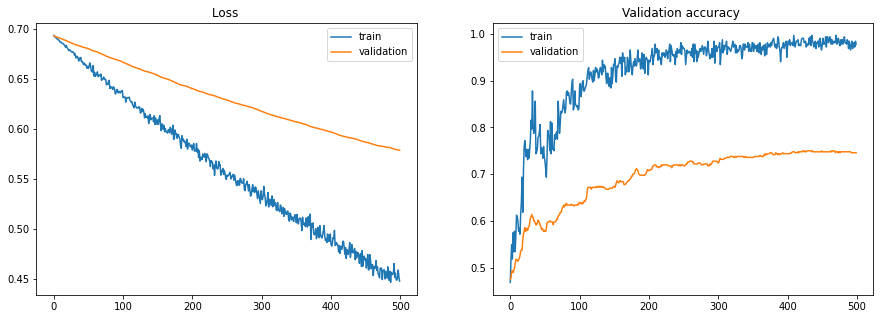

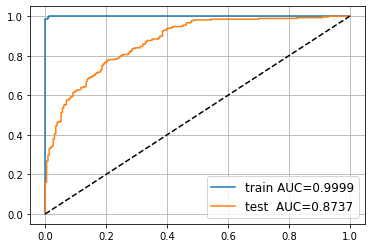

<IPython.core.display.Javascript object>

In [36]:
model = nn.Sequential()

model.add_module("l1", nn.Linear(tfidf_train.shape[1], 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = StepLR(opt, 100)

train_model(
    model,
    opt,
    lr_scheduler,
    X_train_tfidf_torch,
    y_train_torch,
    X_test_tfidf_torch,
    y_test_torch,
    n_iterations=5_000,
)

for name, X, y, model in [
    ("train", X_train_tfidf_torch, y_train, model),
    ("test ", X_test_tfidf_torch, y_test, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

**Validation accuracy shows us that 3000-4000 iteration is enough for train model** 

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

**Let's test complex of the network to check that is the bad idea :)**

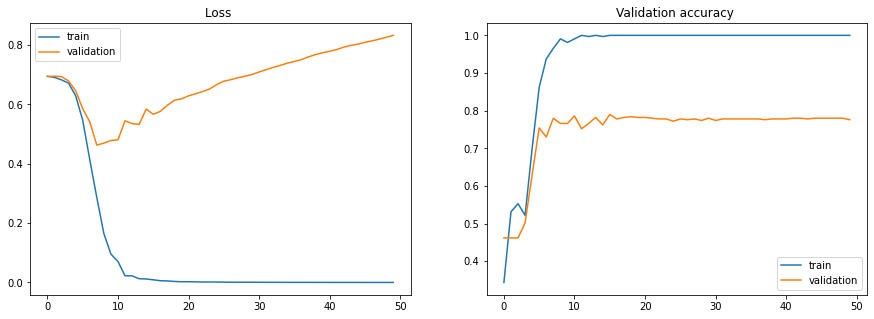

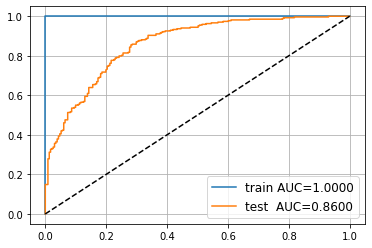

<IPython.core.display.Javascript object>

In [37]:
model = nn.Sequential()

model.add_module("l1", nn.Linear(tfidf_train.shape[1], 3000))
model.add_module("relu1", nn.ReLU())
model.add_module("l2", nn.Linear(3000, 500))
model.add_module("relu2", nn.ReLU())
model.add_module("l3", nn.Linear(500, 2))

loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = StepLR(opt, 100)

train_model(
    model,
    opt,
    lr_scheduler,
    X_train_tfidf_torch,
    y_train_torch,
    X_test_tfidf_torch,
    y_test_torch,
    n_iterations=500,
)

for name, X, y, model in [
    ("train", X_train_tfidf_torch, y_train, model),
    ("test ", X_test_tfidf_torch, y_test, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

**We see that we have overfitted model with degradation for validation. Yes, i agree that increasing the complexity of the network is not a good idea**

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

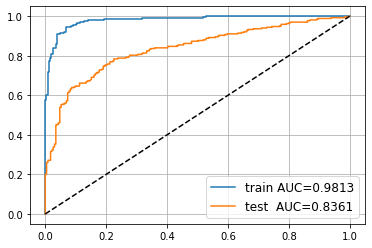

<IPython.core.display.Javascript object>

In [38]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(X_train_bow, y_train)

for name, X, y, model in [
    ("train", X_train_bow, y_train, model),
    ("test ", X_test_bow, y_test, model),
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

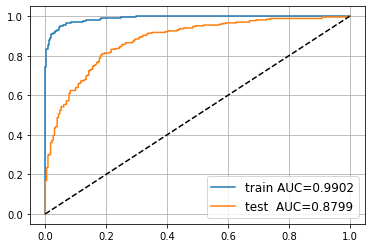

<IPython.core.display.Javascript object>

In [39]:
model = MultinomialNB().fit(tfidf_train, y_train)

for name, X, y, model in [
    ("train", tfidf_train, y_train, model),
    ("test ", tfidf_test, y_test, model),
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")
plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

**We can see that a good result shows NB with tfidf features. which means that NB a good choice when we have a small dataset and get lite and fast model. Increasing complexity for NW didn't help us**

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [40]:
import gensim.downloader as api

<IPython.core.display.Javascript object>

In [41]:
model_glove = api.load("glove-wiki-gigaword-300")

<IPython.core.display.Javascript object>

In [42]:
tokens_train = map(lambda x: list(x.split()), texts_train)
tokens_test = map(lambda x: list(x.split()), texts_test)

<IPython.core.display.Javascript object>

In [43]:
def to_embedding(word2vec_model, tokens):
    vector = np.zeros([word2vec_model.vector_size], dtype="float32")
    word_vectors = [
        word2vec_model[token]
        for token in tokens
        if token in word2vec_model.vocab.keys()
    ]
    return np.mean(word_vectors, axis=0)

<IPython.core.display.Javascript object>

In [44]:
train_stack = np.stack([to_embedding(model_glove, doc) for doc in tokens_train])
test_stack = np.stack([to_embedding(model_glove, doc) for doc in tokens_test])

train_torch = torch.tensor(train_stack.astype("float32"))
test_torch = torch.tensor(test_stack.astype("float32"))

model = nn.Sequential()
model.add_module("l1", nn.Linear(train_torch.shape[1], 2))
model[0].reset_parameters()

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

lr_scheduler = ReduceLROnPlateau(opt, patience=20)

<IPython.core.display.Javascript object>

### 500 iterations

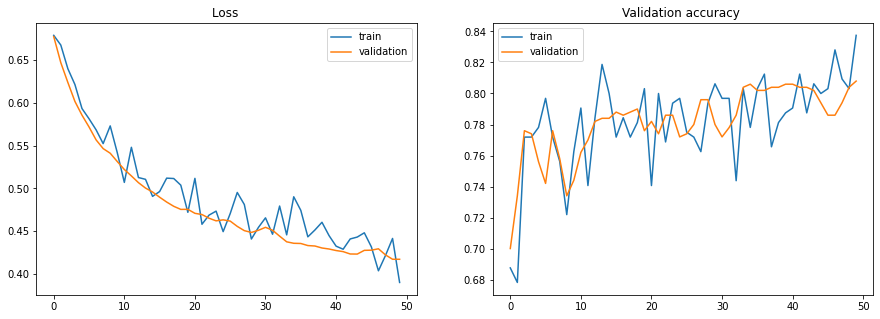

Sequential(
  (l1): Linear(in_features=300, out_features=2, bias=True)
)

<IPython.core.display.Javascript object>

In [45]:
train_model(
    model,
    opt,
    lr_scheduler,
    train_torch,
    y_train_torch,
    test_torch,
    y_test_torch,
    show_plots=True,
    n_iterations=500,
)

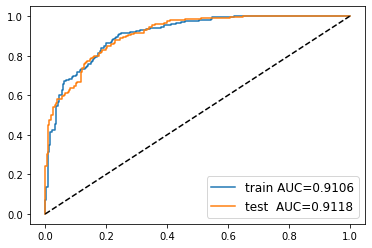

<IPython.core.display.Javascript object>

In [46]:
for name, X, y, model in [
    ("train", train_torch, y_train_torch, model),
    ("test ", test_torch, y_test_torch, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")

### 1000 iterations

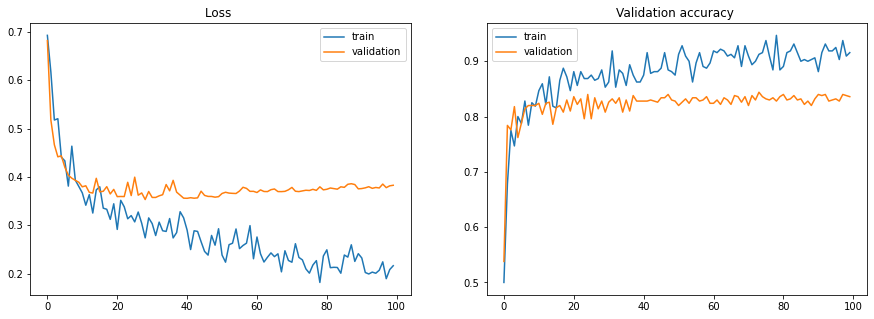

Sequential(
  (l1): Linear(in_features=300, out_features=2, bias=True)
)

<IPython.core.display.Javascript object>

In [47]:
model = nn.Sequential()
model.add_module("l1", nn.Linear(train_torch.shape[1], 2))
model[0].reset_parameters()

opt = torch.optim.Adam(model.parameters(), lr=1e-2)

lr_scheduler = ReduceLROnPlateau(opt, patience=20)

train_model(
    model,
    opt,
    lr_scheduler,
    train_torch,
    y_train_torch,
    test_torch,
    y_test_torch,
    show_plots=True,
    n_iterations=1000,
)

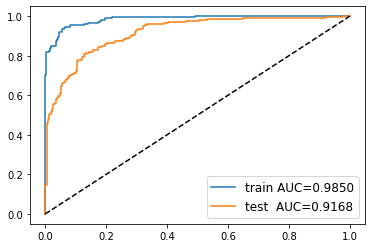

<IPython.core.display.Javascript object>

In [48]:
for name, X, y, model in [
    ("train", train_torch, y_train_torch, model),
    ("test ", test_torch, y_test_torch, model),
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label="%s AUC=%.4f" % (name, auc))

plt.plot(
    [0, 1],
    [0, 1],
    "--",
    color="black",
)
plt.legend(fontsize="large")

**word2vec pretrained model shows significant improvement( if compare with another models LR: 0.83, TFIDF: 0.87, NB: 0.8799) our model and provides better words representation than TFIDF. 
Conclusion: if you can find pre-train models -> try to use them to avoid waste  time training a model from scratch**